# Identifying Common Point of Compromise


This notebook showcases Mo Messidi's analysis of a dataset of debit and credit card transactions to identify the time and place of a common point of comprimise.

## Background:
 

### Transaction Fraud
Many of ABC’s clients are commercial banks, who issue debit and credit cards to customers. The customers then use these cards to make purchases at various merchants (for example, Amazon, Tesco etc). Information about each purchase or attempted purchase is stored as a transaction record by the commercial bank.

A fraudulent transaction is an unauthorised use of a card. A fraudster may use a stolen card or card details (card number, security code, PIN number) to make a purchase or to withdraw money from an account. The information required to commit fraud may have been acquired opportunistically, for example by finding a lost card. However, in many cases, card data will have been acquired at a common point of compromise 

### Common Points of Compromise
A common point of compromise is a breach point used by fraudsters to collect card data. This can be a physical location, such as a skimmer fitted on an ATM; alternatively, a virtual breach, such as data stolen from a merchant’s database of transactions, can be the point of compromise. Identifying common points of compromise is important for commercial banks, as it allows them to block or monitor other accounts at risk of fraud. 

Exploitation of a common point of compromise typically occurs in a two-stage process. This is illustrated in the schematic plot below.

In the first stage of the compromise, account details are harvested from the compromise point. In the second stage of the compromise, these compromised account details are used to make fraudulent transactions. There is typically a delay of several days between harvest and exploit, as it takes time for a fraudster to process the data that they have harvested.

In a set of transactions, a common point of compromise can be identified when an unusually high number of defrauded accounts transacted with the same merchant some time before fraudulent transactions were seen for that account.

## The objectives of the analysis are to:

- Identify the compromised merchant
- Identify the dates of the compromise
- Identify the date of the exploitation

Code is using Python3. The imported libraries are numpy, pandas and matplotlib.
The dataset .csv file should be in the same folder as this code

### Import Requirements

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt




## Load data

In [2]:
df = pd.read_csv('transaction.csv')

df.head(5)

,account,date,fraud,merchant
0,A0,2015-01-01,False,M98
1,A0,2015-01-01,False,M50
2,A0,2015-01-01,False,M55
3,A0,2015-01-01,False,M14
4,A0,2015-01-01,False,M10


### Exploratory Data Anlysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89851 entries, 0 to 89850
Data columns (total 4 columns):
account     89851 non-null object
date        89851 non-null object
fraud       89851 non-null bool
merchant    89851 non-null object
dtypes: bool(1), object(3)
memory usage: 2.1+ MB


### Observations :
- Dataset has 4 features [account, date, fraud, merchant]
- Dataset has 89851 records each representing a transation
- Dataset contains no null values
- date column is in string format 


### Actions: 
It would be more appropirate to change the date column to datetime format.

In [4]:
df['date'] = pd.to_datetime(df['date'])

df.describe(include='all')

,account,date,fraud,merchant
count,89851,89851,89851,89851
unique,1000,30,2,100
top,A831,2015-01-12 00:00:00,False,M8
freq,121,3081,88503,998
first,NaN,2015-01-01 00:00:00,NaN,NaN
last,NaN,2015-01-30 00:00:00,NaN,NaN


### Observations: 
- Dataset contins 1000 accounts, 100 merchants
- The transactions span 30 days from 2015-01-01 to 2015-01-30
- A831 is the count with most transactions
- M8 is the merchant most transacted from
- Out of the all 8951 transations 88503 are true => 1348 are fraudulent

### Actions:
Given the that only 1348 transactions were fraudulent out of 8951. Plotting a histogram of fraudulent transations per day may reveal dates of interest.

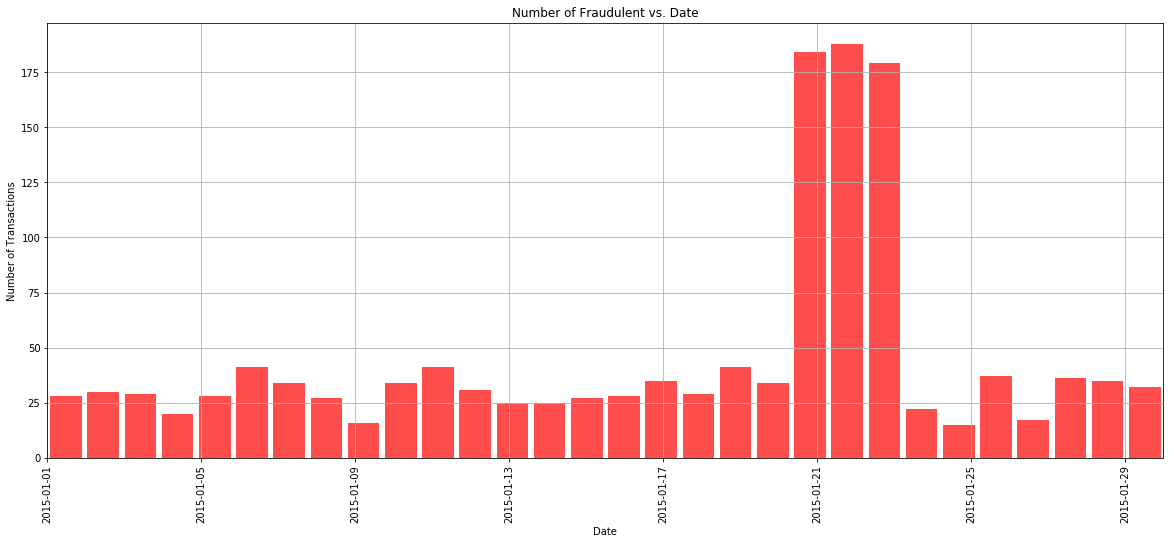

In [5]:
fraud_transactions = df[df['fraud'] == True]

# the histogram of fraudulent transactions by day
plt.figure(figsize=(20,8))
plt.hist(x=fraud_transactions['date'],bins=30,alpha=0.7, rwidth=0.85, color='red')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.title('Number of Fraudulent vs. Date')
plt.xticks(rotation='vertical')
plt.grid(True)
plt.xlim([pd.Timestamp(2015,1,1),pd.Timestamp(2015,1,30)])
plt.savefig('plot1.png')
plt.show()

### Observatons
- The date range 2015-01-21 to 2015-01-23 has a very high number of fraudulent transactions: ~175
- All other days have closer to 30 fradulent transactions.
- The date range 2015-01-21 to 2015-01-23 is a very strong canidate for exploit period of after a point of compromise.

## Actions
Given this date range of interest. Exploring the accounts used in this period could provide information on accounts used in the common point of compromise.


In [6]:
# get transactions in exploit perdiod
exploit_transations = fraud_transactions[(fraud_transactions['date'] >= pd.Timestamp(2015,1,21)) &
                                         (fraud_transactions['date'] <= pd.Timestamp(2015,1,23))]

#list of exploited accounts
exploited_accounts = exploit_transations['account']

exploit_transations.describe()


,account,date,fraud,merchant
count,551,551,551,551
unique,148,3,1,100
top,A746,2015-01-22 00:00:00,True,M24
freq,15,188,551,10
first,NaN,2015-01-21 00:00:00,NaN,NaN
last,NaN,2015-01-23 00:00:00,NaN,NaN


### Observations:
- There were 148 unique accounts used in the exploit period
- Tranactions occurred at all 100 merchants during the exploit period

### Actions
- Given a list of accounts used in the exploit period. Analyzing the transation history of those 148 accounts in the days before the exploit (2015-01-01 to 2015-01-20) could give hints on possible compromised merchants

In [7]:
#get transactions of exploited accounts before exploit stare date
exploited_accounts_history = df[(df['date'] < pd.Timestamp(2015,1,21)) &
                                df['account'].isin(exploited_accounts)]

#find merchants that are common between the heights numbers of exploited accounts
history_per_merchant = exploited_accounts_history.groupby(['merchant'])['account'].nunique().sort_values(ascending=False)
history_per_merchant.head(10)



merchant
M18    91
M8     78
M61    77
M94    76
M53    75
M76    75
M92    74
M31    74
M48    74
M17    73
Name: account, dtype: int64

### Observations:
- 91 out of 128 suspect accounts from the exploit period make a transacton with Merchant 'M18'
- There is a significant jump between number of unique suspect accounts that transacted with Merchant 'M18' and the rest of the top 10 merchants in the list.

### Actions: 
Analysing the distribution of transactions made before the exploit period for the top 3 merchants can confirm which merchant is the compromised one and also hint at the compromise harvest dates

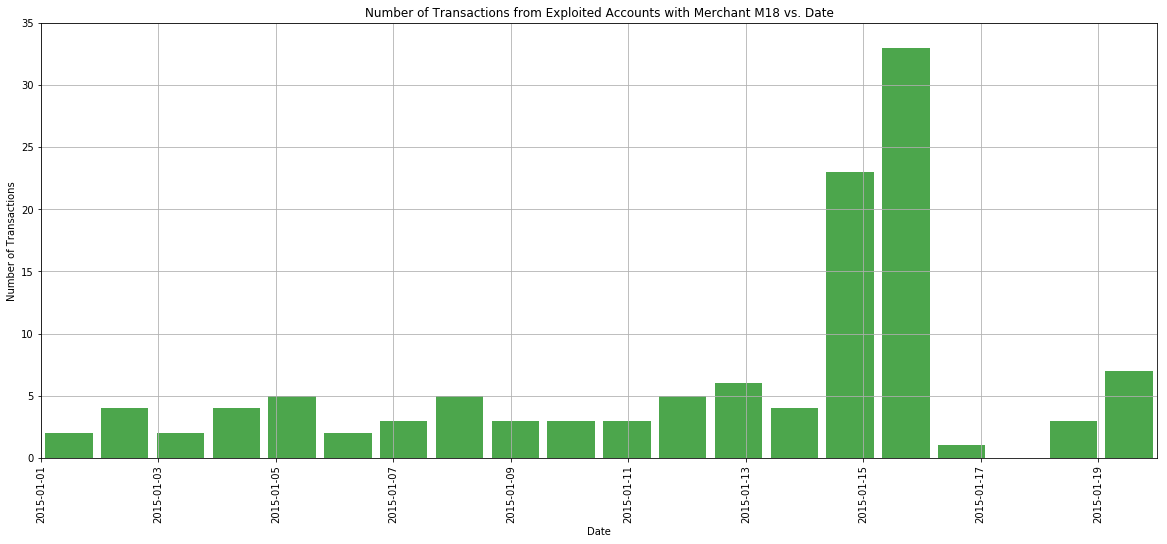

In [8]:

# the histogram of transactions of merchant 'M18' per day from the exploited accounts
plt.figure(figsize=(20,8))
plt.hist(x=exploited_accounts_history[exploited_accounts_history['merchant'] == 'M18']['date'],bins=20,alpha=0.7, rwidth=0.85, color='green')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions from Exploited Accounts with Merchant M18 vs. Date')
plt.xticks(rotation='vertical')
plt.ylim([0,35])
plt.grid(True)
plt.xlim([pd.Timestamp(2015,1,1),pd.Timestamp(2015,1,20)])
plt.savefig('plot2.png')
plt.show()

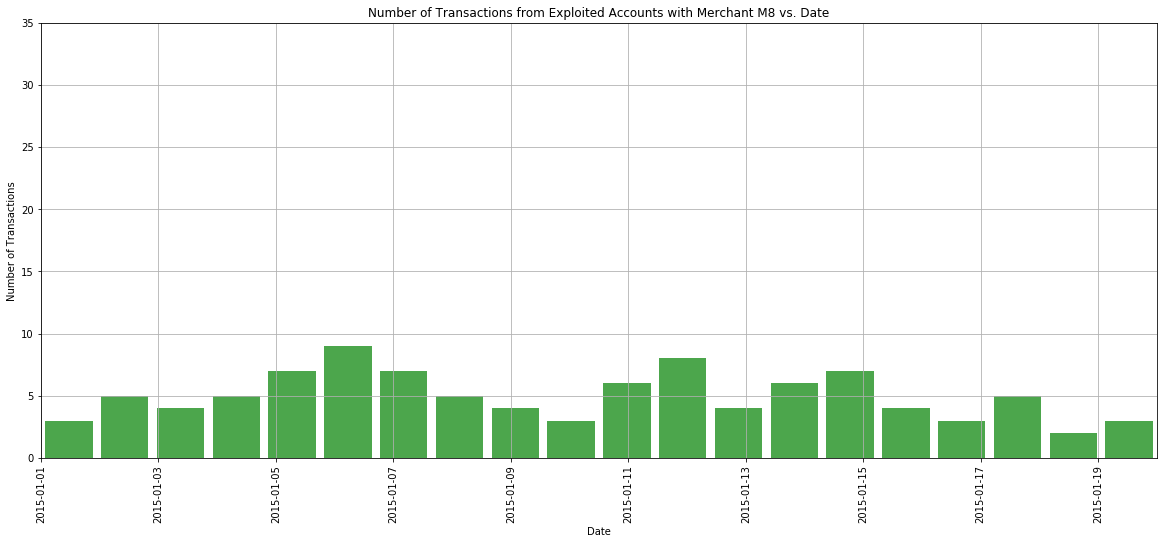

In [9]:
# the histogram of transactions of merchant 'M8' per day from the exploited accounts
plt.figure(figsize=(20,8))
plt.hist(x=exploited_accounts_history[exploited_accounts_history['merchant'] == 'M8']['date'],bins=20,alpha=0.7, rwidth=0.85, color='green')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions from Exploited Accounts with Merchant M8 vs. Date')
plt.ylim((0,35))
plt.xticks(rotation='vertical')
plt.grid(True)
plt.xlim([pd.Timestamp(2015,1,1),pd.Timestamp(2015,1,20)])
plt.savefig('plot3.png')
plt.show()

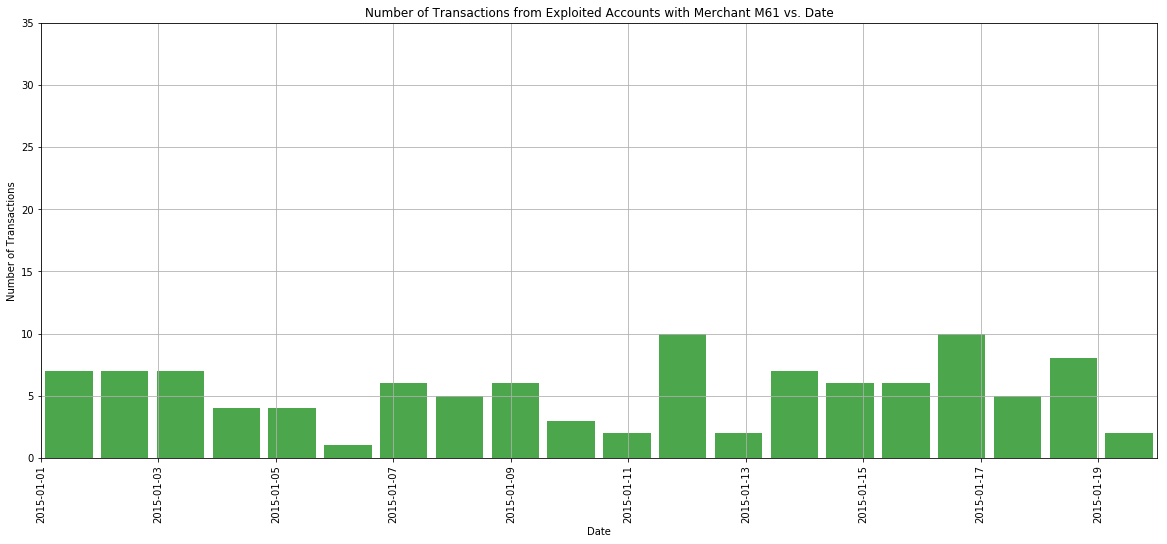

In [10]:
# the histogram of transactions of merchant 'M' per day from the exploited accounts
plt.figure(figsize=(20,8))
plt.hist(x=exploited_accounts_history[exploited_accounts_history['merchant'] == 'M61']['date'],bins=20,alpha=0.7, rwidth=0.85, color='green')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions from Exploited Accounts with Merchant M61 vs. Date')
plt.ylim([0,35])
plt.xticks(rotation='vertical')
plt.grid(True)
plt.xlim([pd.Timestamp(2015,1,1),pd.Timestamp(2015,1,20)])
plt.savefig('plot.png')
plt.show()

### Observations:
- The distribution of transactions is close to uniform for merchants 'M8' and 'M61' esp. when compared to 'M18'
- There is a clear spike in the number of transactions from the exploited accounts in the date range 2015-01-15 to 2015-01-16
- M18 is the best canidate for the compromised merchant
- Date range 2015-01-15 to 2015-01-16 is best canidate for the harvest period.

### Actions
- The identified canidates for the harvest period and the compromised merchant can be further confirmed by comparing the number of exploited accounts that made transactions with the 'M18' in the period of 2015-01-15 to 2015-01-16.


In [11]:
#get transactions of exploited accounts with merchant 'M18' during the harvest period
harvest_period_transactions = df[(df['date'] >= pd.Timestamp(2015,1,15)) &
                                (df['date'] <= pd.Timestamp(2015,1,16)) &
                                (df['merchant'] == 'M18') &
                                df['account'].isin(exploited_accounts)]


harvest_period_transactions.describe()

,account,date,fraud,merchant
count,56,56,56,56
unique,53,2,2,1
top,A203,2015-01-16 00:00:00,False,M18
freq,2,33,55,56
first,NaN,2015-01-15 00:00:00,NaN,NaN
last,NaN,2015-01-16 00:00:00,NaN,NaN


# Results:

- Compromised Merchant :  M18

- Harvest days : From 2015–01–15 until 2015–01–16 inclusive

- Exploit days : From 2015-01-21 until 2015-01-23 inclusive
